CUSTOMER CHURN PREDICTION SYSTEM

1. LOADING DATA...
✓ Dataset loaded from 'telco_churn.csv'

Dataset Shape: (7043, 21)
Columns: ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

Missing Values:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

Target Distribution:
Churn
No     0.73463
Yes    0.265

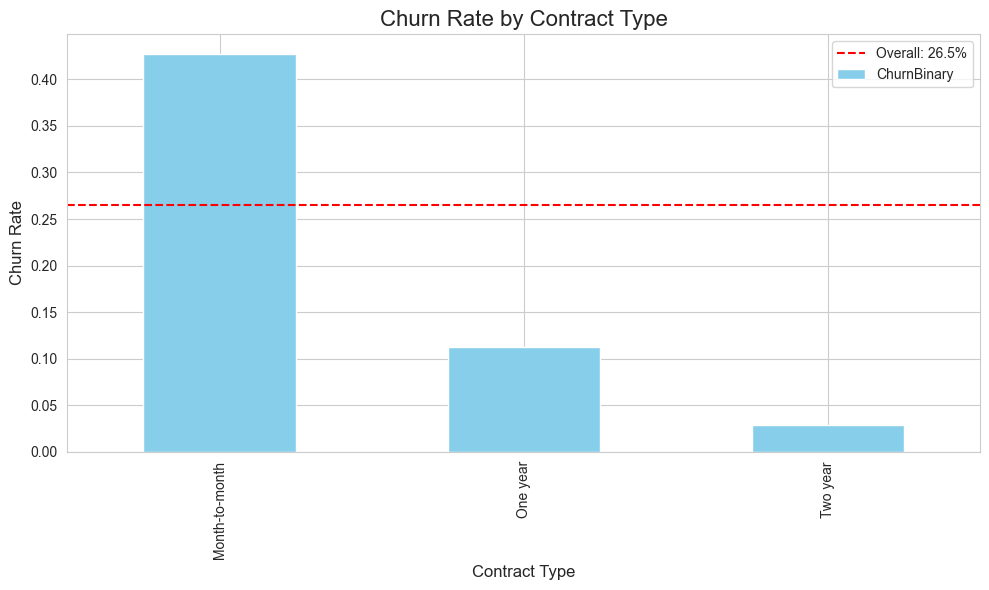

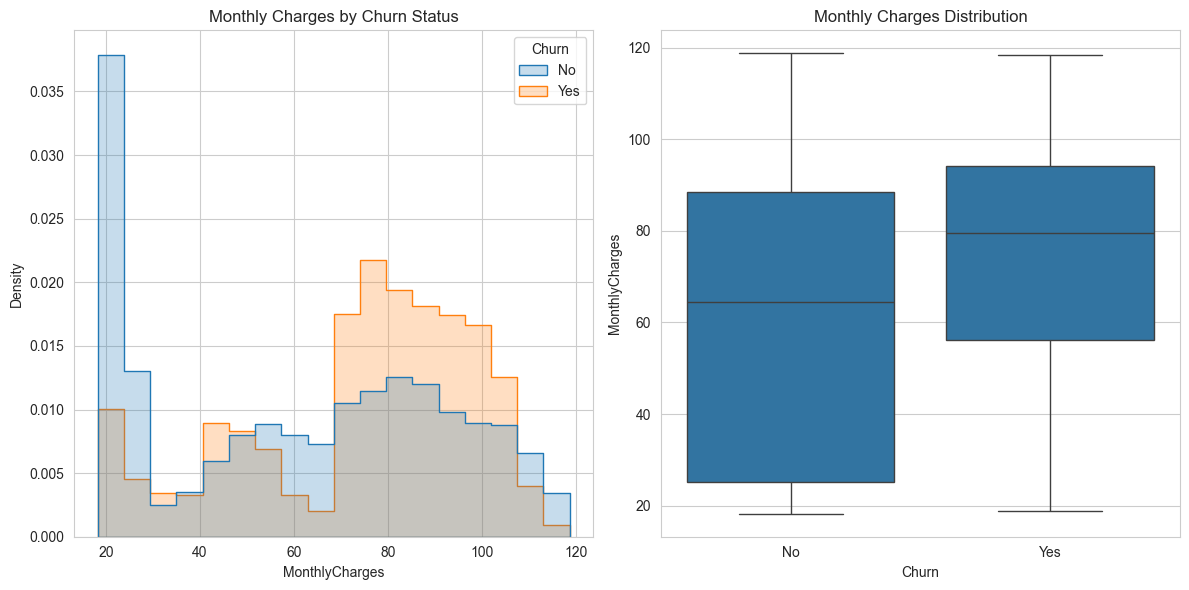

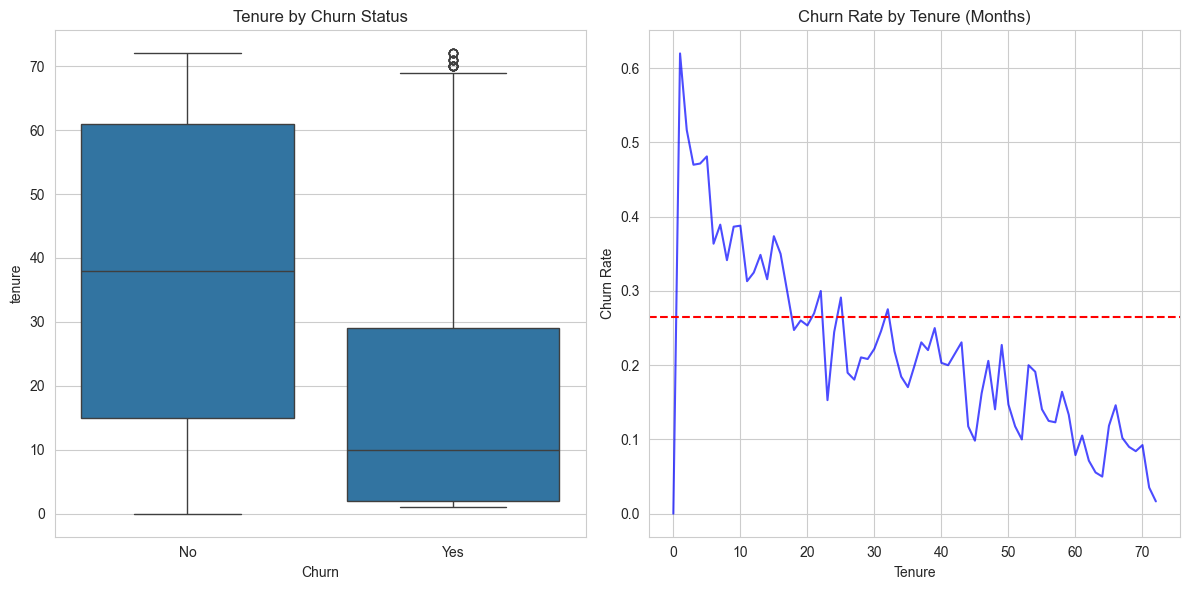

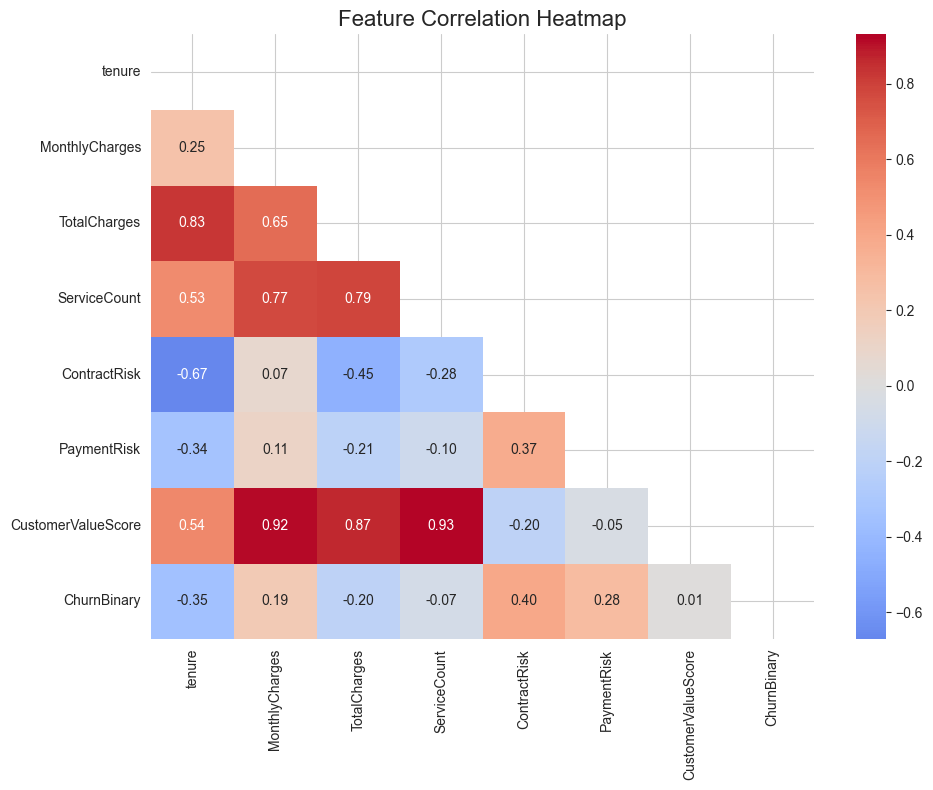

✓ EDA visualizations completed

5. PREPARING DATA FOR MODELING...
  Categorical features: 17
  Numerical features: 8
  Training set: (5634, 28)
  Testing set: (1409, 28)
  Train churn rate: 26.5%
  Test churn rate: 26.5%

6. CREATING PREPROCESSING PIPELINE...
✓ Preprocessing pipeline created

7. HANDLING IMBALANCED DATA...
  Class weights: {0: 0.6805991785455424, 1: 1.8842809364548494}
✓ Using SMOTE for oversampling

8. BUILDING MODELS...

Training Progress:
----------------------------------------
  Training Logistic Regression... ✓ Complete (Recall: 0.791)
  Training Random Forest... ✓ Complete (Recall: 0.690)
  Training Gradient Boosting... ✓ Complete (Recall: 0.663)
  Training XGBoost... ✓ Complete (Recall: 0.663)

9. MODEL EVALUATION...

MODEL PERFORMANCE COMPARISON:
                    Accuracy Precision  Recall F1_Score ROC_AUC Avg_Precision
Logistic Regression   0.7381    0.5043  0.7914   0.6160  0.8386        0.6284
Random Forest         0.7715    0.5560  0.6898   0.6158  0.83

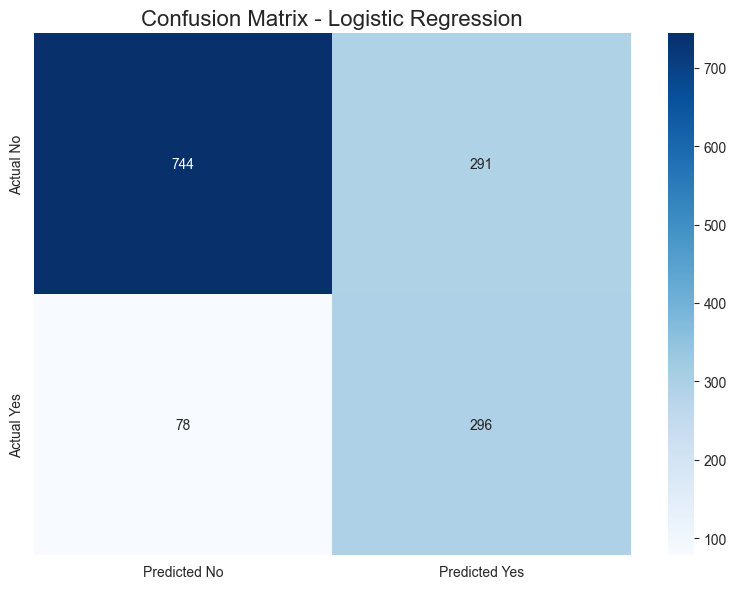

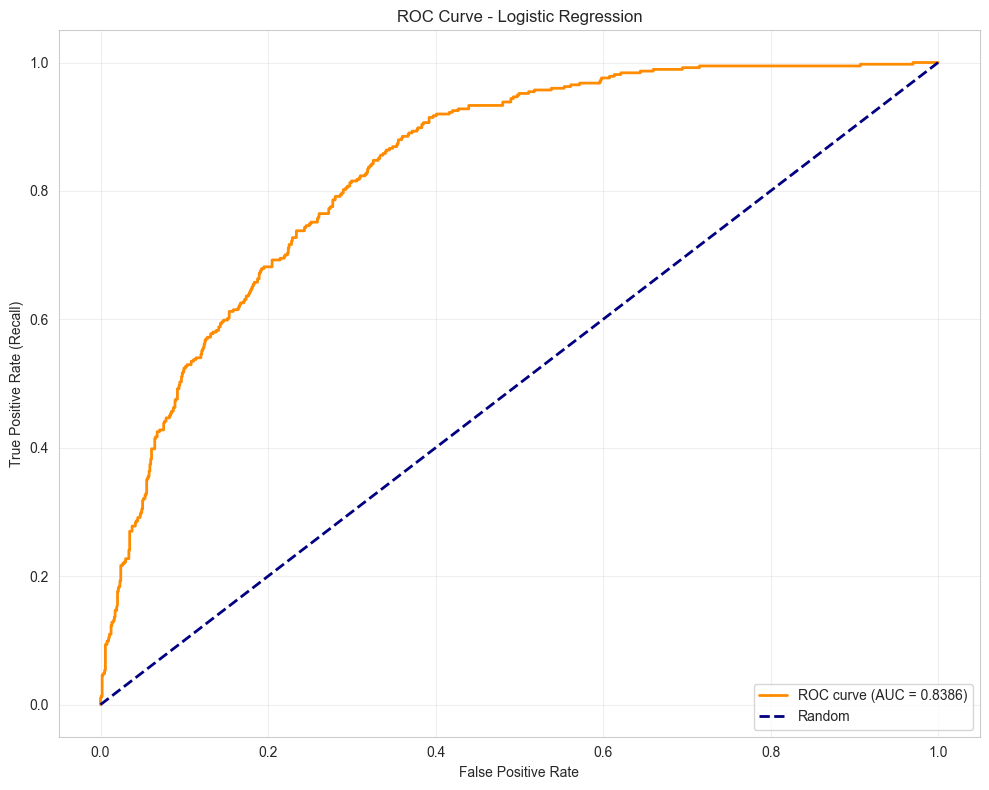


10. BUSINESS INSIGHTS & RECOMMENDATIONS

KEY FINDINGS:
----------------------------------------
1. CONTRACT TYPE IMPACT:
                Churn_Rate  Customer_Count
Contract                                  
Month-to-month       0.427            3875
One year             0.113            1473
Two year             0.028            1695

2. TENURE IMPACT:
             Churn_Rate  Customer_Count
TenureGroup                            
Loyal             0.119            3001
Mid               0.255            1856
New               0.474            2186

3. SERVICE IMPACT:
       Service With_Service Without_Service Difference
OnlineSecurity        14.6%           31.3%      16.7%
   TechSupport        15.2%           31.2%      16.0%
   StreamingTV        30.1%           24.3%      -5.7%

4. PAYMENT METHOD IMPACT:
  Electronic check: 45.3%
  Mailed check: 19.1%
  Bank transfer (automatic): 16.7%
  Credit card (automatic): 15.2%

------------------------------------------------------------

In [11]:
# ============================================
# CUSTOMER CHURN PREDICTION - FULL OPTIMIZED CODE
# ============================================

# 1. IMPORT NECESSARY LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             classification_report, roc_curve, precision_recall_curve,
                             average_precision_score)

# Visualization settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
warnings.filterwarnings('ignore')

print("="*80)
print("CUSTOMER CHURN PREDICTION SYSTEM")
print("="*80)

# ============================================
# 2. LOAD AND INSPECT DATA
# ============================================
print("\n1. LOADING DATA...")

def load_data(filepath='telco_churn.csv'):
    """Load the churn dataset with error handling."""
    try:
        if os.path.exists(filepath):
            df = pd.read_csv(filepath)
            print(f"✓ Dataset loaded from '{filepath}'")
            return df
        else:
            print(f"⚠ File '{filepath}' not found. Creating sample data...")
            return create_sample_data()
    except Exception as e:
        print(f"⚠ Error loading data: {e}")
        print("Creating sample data...")
        return create_sample_data()

def create_sample_data():
    """Create sample data if real data is not available."""
    np.random.seed(42)
    n_samples = 5000
    
    data = {
        'customerID': [f'CUST{i:05d}' for i in range(n_samples)],
        'gender': np.random.choice(['Male', 'Female'], n_samples),
        'SeniorCitizen': np.random.choice([0, 1], n_samples, p=[0.8, 0.2]),
        'Partner': np.random.choice(['Yes', 'No'], n_samples),
        'Dependents': np.random.choice(['Yes', 'No'], n_samples),
        'tenure': np.random.randint(1, 72, n_samples),
        'PhoneService': np.random.choice(['Yes', 'No'], n_samples, p=[0.9, 0.1]),
        'MultipleLines': np.random.choice(['Yes', 'No', 'No phone service'], n_samples, p=[0.4, 0.4, 0.2]),
        'InternetService': np.random.choice(['DSL', 'Fiber optic', 'No'], n_samples, p=[0.35, 0.45, 0.2]),
        'OnlineSecurity': np.random.choice(['Yes', 'No', 'No internet service'], n_samples, p=[0.3, 0.4, 0.3]),
        'OnlineBackup': np.random.choice(['Yes', 'No', 'No internet service'], n_samples, p=[0.3, 0.4, 0.3]),
        'DeviceProtection': np.random.choice(['Yes', 'No', 'No internet service'], n_samples, p=[0.3, 0.4, 0.3]),
        'TechSupport': np.random.choice(['Yes', 'No', 'No internet service'], n_samples, p=[0.25, 0.45, 0.3]),
        'StreamingTV': np.random.choice(['Yes', 'No', 'No internet service'], n_samples, p=[0.35, 0.35, 0.3]),
        'StreamingMovies': np.random.choice(['Yes', 'No', 'No internet service'], n_samples, p=[0.35, 0.35, 0.3]),
        'Contract': np.random.choice(['Month-to-month', 'One year', 'Two year'], n_samples, p=[0.55, 0.25, 0.2]),
        'PaperlessBilling': np.random.choice(['Yes', 'No'], n_samples, p=[0.6, 0.4]),
        'PaymentMethod': np.random.choice(['Electronic check', 'Mailed check', 'Bank transfer (automatic)', 'Credit card (automatic)'], 
                                          n_samples, p=[0.35, 0.25, 0.2, 0.2]),
        'MonthlyCharges': np.round(np.random.uniform(20, 120, n_samples), 2),
        'TotalCharges': np.round(np.random.uniform(50, 8000, n_samples), 2),
        'Churn': np.random.choice(['Yes', 'No'], n_samples, p=[0.27, 0.73])
    }
    
    df = pd.DataFrame(data)
    print("✓ Sample data created (5000 records)")
    return df

# Load data
df = load_data()

print(f"\nDataset Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nMissing Values:\n{df.isnull().sum()}")

# Display basic info
print(f"\nTarget Distribution:")
churn_dist = df['Churn'].value_counts(normalize=True)
print(churn_dist)
print(f"Churn Rate: {churn_dist.get('Yes', 0)*100:.2f}%")

# ============================================
# 3. DATA CLEANING
# ============================================
print("\n" + "="*80)
print("2. DATA CLEANING...")

df_clean = df.copy()

# Convert TotalCharges to numeric
df_clean['TotalCharges'] = pd.to_numeric(df_clean['TotalCharges'], errors='coerce')
missing_total = df_clean['TotalCharges'].isnull().sum()
print(f"  Found {missing_total} missing values in TotalCharges")

# Fill missing TotalCharges with 0 (new customers)
df_clean['TotalCharges'] = df_clean['TotalCharges'].fillna(0)

# Convert SeniorCitizen to categorical
df_clean['SeniorCitizen'] = df_clean['SeniorCitizen'].map({0: 'No', 1: 'Yes'})

# Clean service columns
service_columns = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                   'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']

for col in service_columns:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].replace({'No internet service': 'No', 'No phone service': 'No'})

print("✓ Data cleaning completed")

# ============================================
# 4. FEATURE ENGINEERING
# ============================================
print("\n" + "="*80)
print("3. FEATURE ENGINEERING...")

# 1. Average monthly revenue
df_clean['AvgMonthlyRevenue'] = df_clean['TotalCharges'] / np.where(df_clean['tenure'] > 0, df_clean['tenure'], 1)

# 2. Tenure groups
def tenure_group(tenure):
    if tenure <= 12:
        return 'New'
    elif tenure <= 36:
        return 'Mid'
    else:
        return 'Loyal'

df_clean['TenureGroup'] = df_clean['tenure'].apply(tenure_group)

# 3. Service count
service_cols = [col for col in service_columns if col in df_clean.columns]
df_clean['ServiceCount'] = df_clean[service_cols].apply(lambda x: (x == 'Yes').sum(), axis=1)

# 4. Premium service flags
df_clean['HasPremiumInternet'] = (df_clean['InternetService'] == 'Fiber optic').astype(int)
df_clean['HasMultipleServices'] = (df_clean['ServiceCount'] > 3).astype(int)

# 5. Contract risk score
contract_risk = {'Month-to-month': 3, 'One year': 2, 'Two year': 1}
df_clean['ContractRisk'] = df_clean['Contract'].map(contract_risk)

# 6. Payment method risk
payment_risk = {'Electronic check': 3, 'Mailed check': 2, 
                'Bank transfer (automatic)': 1, 'Credit card (automatic)': 1}
df_clean['PaymentRisk'] = df_clean['PaymentMethod'].map(payment_risk)

# 7. Customer value score
df_clean['MonthlyChargesNorm'] = (df_clean['MonthlyCharges'] - df_clean['MonthlyCharges'].min()) / (df_clean['MonthlyCharges'].max() - df_clean['MonthlyCharges'].min())
df_clean['TotalChargesNorm'] = (df_clean['TotalCharges'] - df_clean['TotalCharges'].min()) / (df_clean['TotalCharges'].max() - df_clean['TotalCharges'].min())
df_clean['ServiceCountNorm'] = (df_clean['ServiceCount'] - df_clean['ServiceCount'].min()) / (df_clean['ServiceCount'].max() - df_clean['ServiceCount'].min())

df_clean['CustomerValueScore'] = (df_clean['MonthlyChargesNorm'] * 0.4 + 
                                  df_clean['TotalChargesNorm'] * 0.3 + 
                                  df_clean['ServiceCountNorm'] * 0.3)

# Drop temporary columns
df_clean = df_clean.drop(['MonthlyChargesNorm', 'TotalChargesNorm', 'ServiceCountNorm'], axis=1)

# 8. High risk flag
df_clean['HighRiskFlag'] = ((df_clean['Contract'] == 'Month-to-month') & 
                           (df_clean['PaymentMethod'] == 'Electronic check')).astype(int)

# 9. Binary target variable
df_clean['ChurnBinary'] = df_clean['Churn'].map({'No': 0, 'Yes': 1})

print(f"✓ Created {len(df_clean.columns) - len(df.columns)} new features")
print(f"  Total features: {len(df_clean.columns)}")

# ============================================
# 5. EXPLORATORY DATA ANALYSIS (EDA)
# ============================================
print("\n" + "="*80)
print("4. EXPLORATORY DATA ANALYSIS...")

# 1. Churn by contract type
plt.figure(figsize=(10, 6))
churn_by_contract = df_clean.groupby('Contract')['ChurnBinary'].mean().sort_values(ascending=False)
churn_by_contract.plot(kind='bar', color='skyblue')
plt.title('Churn Rate by Contract Type', fontsize=16)
plt.xlabel('Contract Type', fontsize=12)
plt.ylabel('Churn Rate', fontsize=12)
plt.axhline(y=df_clean['ChurnBinary'].mean(), color='red', linestyle='--', 
            label=f'Overall: {df_clean["ChurnBinary"].mean():.1%}')
plt.legend()
plt.tight_layout()
plt.show()

# 2. Monthly charges distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(data=df_clean, x='MonthlyCharges', hue='Churn', element='step', stat='density', common_norm=False)
plt.title('Monthly Charges by Churn Status')

plt.subplot(1, 2, 2)
sns.boxplot(x='Churn', y='MonthlyCharges', data=df_clean)
plt.title('Monthly Charges Distribution')
plt.tight_layout()
plt.show()

# 3. Tenure analysis
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x='Churn', y='tenure', data=df_clean)
plt.title('Tenure by Churn Status')

plt.subplot(1, 2, 2)
tenure_churn = df_clean.groupby('tenure')['ChurnBinary'].mean()
plt.plot(tenure_churn.index, tenure_churn.values, color='blue', alpha=0.7)
plt.axhline(y=df_clean['ChurnBinary'].mean(), color='red', linestyle='--')
plt.title('Churn Rate by Tenure (Months)')
plt.xlabel('Tenure')
plt.ylabel('Churn Rate')
plt.tight_layout()
plt.show()

# 4. Correlation heatmap
numeric_cols_for_corr = ['tenure', 'MonthlyCharges', 'TotalCharges', 'ServiceCount', 
                         'ContractRisk', 'PaymentRisk', 'CustomerValueScore', 'ChurnBinary']
numeric_cols_for_corr = [col for col in numeric_cols_for_corr if col in df_clean.columns]

if len(numeric_cols_for_corr) > 1:
    plt.figure(figsize=(10, 8))
    corr_matrix = df_clean[numeric_cols_for_corr].corr()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', center=0, fmt='.2f')
    plt.title('Feature Correlation Heatmap', fontsize=16)
    plt.tight_layout()
    plt.show()

print("✓ EDA visualizations completed")

# ============================================
# 6. PREPARE DATA FOR MODELING
# ============================================
print("\n" + "="*80)
print("5. PREPARING DATA FOR MODELING...")

# Separate features and target
X = df_clean.drop(['Churn', 'ChurnBinary', 'customerID'], axis=1, errors='ignore')
y = df_clean['ChurnBinary']

# Identify column types
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"  Categorical features: {len(categorical_cols)}")
print(f"  Numerical features: {len(numeric_cols)}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"  Training set: {X_train.shape}")
print(f"  Testing set: {X_test.shape}")
print(f"  Train churn rate: {y_train.mean():.1%}")
print(f"  Test churn rate: {y_test.mean():.1%}")

# ============================================
# 7. CREATE PREPROCESSING PIPELINE
# ============================================
print("\n" + "="*80)
print("6. CREATING PREPROCESSING PIPELINE...")

# Numerical pipeline
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical pipeline
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine pipelines
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

print("✓ Preprocessing pipeline created")

# ============================================
# 8. HANDLE IMBALANCED DATA
# ============================================
print("\n" + "="*80)
print("7. HANDLING IMBALANCED DATA...")

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print(f"  Class weights: {class_weight_dict}")

# SMOTE for oversampling
smote = SMOTE(random_state=42)
print("✓ Using SMOTE for oversampling")

# ============================================
# 9. MODEL BUILDING
# ============================================
print("\n" + "="*80)
print("8. BUILDING MODELS...")

# Define models with simplified parameters (to avoid GridSearchCV issues)
models_config = {
    'Logistic Regression': {
        'model': LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000),
        'params': {
            'classifier__C': [0.1, 1],
            'classifier__solver': ['liblinear']
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42, class_weight='balanced'),
        'params': {
            'classifier__n_estimators': [100],
            'classifier__max_depth': [10, 20]
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'classifier__n_estimators': [100],
            'classifier__learning_rate': [0.1, 0.2]
        }
    },
    'XGBoost': {
        'model': xgb.XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False),
        'params': {
            'classifier__n_estimators': [100],
            'classifier__learning_rate': [0.1, 0.2],
            'classifier__max_depth': [3, 5]
        }
    }
}

results = {}
best_models = {}
trained_models = []

print("\nTraining Progress:")
print("-"*40)

# Train each model
for name, config in models_config.items():
    print(f"  Training {name}...", end=' ')
    
    try:
        # Create pipeline
        pipeline = ImbPipeline([
            ('preprocessor', preprocessor),
            ('smote', smote),
            ('classifier', config['model'])
        ])
        
        # Use GridSearchCV with n_jobs=1 to avoid multiprocessing issues
        grid_search = GridSearchCV(
            pipeline,
            config['params'],
            cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
            scoring='recall',
            n_jobs=1,  # Single job to avoid serialization issues
            verbose=0
        )
        
        grid_search.fit(X_train, y_train)
        
        # Store results
        best_models[name] = grid_search.best_estimator_
        trained_models.append(name)
        
        # Predict on test set
        y_pred = grid_search.predict(X_test)
        y_pred_proba = grid_search.predict_proba(X_test)[:, 1]
        
        # Calculate metrics
        results[name] = {
            'Best_Params': str(grid_search.best_params_),
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred, zero_division=0),
            'Recall': recall_score(y_test, y_pred),
            'F1_Score': f1_score(y_test, y_pred),
            'ROC_AUC': roc_auc_score(y_test, y_pred_proba),
            'Avg_Precision': average_precision_score(y_test, y_pred_proba)
        }
        
        print(f"✓ Complete (Recall: {results[name]['Recall']:.3f})")
        
    except Exception as e:
        print(f"✗ Failed: {str(e)}")
        # Try without grid search
        try:
            pipeline = ImbPipeline([
                ('preprocessor', preprocessor),
                ('smote', smote),
                ('classifier', config['model'])
            ])
            pipeline.fit(X_train, y_train)
            best_models[name] = pipeline
            trained_models.append(name)
            
            y_pred = pipeline.predict(X_test)
            y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
            
            results[name] = {
                'Best_Params': 'Default',
                'Accuracy': accuracy_score(y_test, y_pred),
                'Precision': precision_score(y_test, y_pred, zero_division=0),
                'Recall': recall_score(y_test, y_pred),
                'F1_Score': f1_score(y_test, y_pred),
                'ROC_AUC': roc_auc_score(y_test, y_pred_proba),
                'Avg_Precision': average_precision_score(y_test, y_pred_proba)
            }
            print(f"✓ Complete with default params (Recall: {results[name]['Recall']:.3f})")
        except:
            print(f"✗ Could not train {name}")

# ============================================
# 10. MODEL EVALUATION
# ============================================
print("\n" + "="*80)
print("9. MODEL EVALUATION...")

if results:
    # Create results dataframe
    results_df = pd.DataFrame(results).T
    
    # Ensure numeric columns are numeric
    numeric_metrics = ['Accuracy', 'Precision', 'Recall', 'F1_Score', 'ROC_AUC', 'Avg_Precision']
    for metric in numeric_metrics:
        if metric in results_df.columns:
            results_df[metric] = pd.to_numeric(results_df[metric], errors='coerce')
    
    # Display results
    print("\nMODEL PERFORMANCE COMPARISON:")
    print("="*80)
    
    # Format numeric columns
    display_df = results_df[numeric_metrics].copy()
    for col in display_df.columns:
        display_df[col] = display_df[col].apply(lambda x: f"{x:.4f}" if pd.notnull(x) else "N/A")
    
    print(display_df.sort_values('Recall', ascending=False))
    
    # Select best model
    if 'Recall' in results_df.columns and not results_df['Recall'].isnull().all():
        best_model_name = results_df['Recall'].idxmax()
        best_model = best_models.get(best_model_name)
        
        if best_model:
            print(f"\n" + "="*80)
            print(f"BEST MODEL: {best_model_name}")
            print("="*80)
            print(f"Recall: {results_df.loc[best_model_name, 'Recall']:.4f}")
            print(f"F1-Score: {results_df.loc[best_model_name, 'F1_Score']:.4f}")
            print(f"ROC-AUC: {results_df.loc[best_model_name, 'ROC_AUC']:.4f}")
            
            # Detailed evaluation
            print(f"\n" + "-"*80)
            print("DETAILED EVALUATION")
            print("-"*80)
            
            y_pred_best = best_model.predict(X_test)
            y_pred_proba_best = best_model.predict_proba(X_test)[:, 1]
            
            print("\nClassification Report:")
            print(classification_report(y_test, y_pred_best, target_names=['No Churn', 'Churn']))
            
            # Confusion Matrix
            plt.figure(figsize=(8, 6))
            cm = confusion_matrix(y_test, y_pred_best)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                       xticklabels=['Predicted No', 'Predicted Yes'],
                       yticklabels=['Actual No', 'Actual Yes'])
            plt.title(f'Confusion Matrix - {best_model_name}', fontsize=16)
            plt.tight_layout()
            plt.show()
            
            # ROC Curve
            plt.figure(figsize=(10, 8))
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba_best)
            plt.plot(fpr, tpr, color='darkorange', lw=2, 
                    label=f'ROC curve (AUC = {roc_auc_score(y_test, y_pred_proba_best):.4f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate (Recall)')
            plt.title(f'ROC Curve - {best_model_name}')
            plt.legend(loc="lower right")
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            
            # Feature Importance (for tree-based models)
            if hasattr(best_model.named_steps['classifier'], 'feature_importances_'):
                try:
                    # Get feature names
                    preprocessor.fit(X_train)
                    X_train_transformed = preprocessor.transform(X_train)
                    
                    # Extract feature names
                    numeric_features = numeric_cols
                    categorical_features = preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_cols)
                    all_features = list(numeric_features) + list(categorical_features)
                    
                    # Get importances
                    importances = best_model.named_steps['classifier'].feature_importances_
                    
                    # Create importance dataframe
                    importance_df = pd.DataFrame({
                        'Feature': all_features,
                        'Importance': importances
                    }).sort_values('Importance', ascending=False).head(15)
                    
                    # Plot
                    plt.figure(figsize=(12, 8))
                    sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
                    plt.title(f'Top 15 Feature Importances - {best_model_name}', fontsize=16)
                    plt.tight_layout()
                    plt.show()
                    
                    print("\nTop 10 Most Important Features:")
                    print(importance_df.head(10).to_string(index=False))
                    
                except Exception as e:
                    print(f"\nNote: Could not generate feature importance: {str(e)}")
            
    else:
        print("\n⚠ Could not determine best model - no valid recall scores")
else:
    print("\n⚠ No models were successfully trained")

# ============================================
# 11. BUSINESS INSIGHTS
# ============================================
print("\n" + "="*80)
print("10. BUSINESS INSIGHTS & RECOMMENDATIONS")
print("="*80)

print("\nKEY FINDINGS:")
print("-"*40)

# 1. Contract Analysis
print("1. CONTRACT TYPE IMPACT:")
contract_stats = df_clean.groupby('Contract').agg({
    'ChurnBinary': ['mean', 'count']
}).round(3)
contract_stats.columns = ['Churn_Rate', 'Customer_Count']
print(contract_stats.sort_values('Churn_Rate', ascending=False))

# 2. Tenure Analysis
print("\n2. TENURE IMPACT:")
tenure_stats = df_clean.groupby('TenureGroup').agg({
    'ChurnBinary': ['mean', 'count']
}).round(3)
tenure_stats.columns = ['Churn_Rate', 'Customer_Count']
print(tenure_stats)

# 3. Service Analysis
print("\n3. SERVICE IMPACT:")
service_impact = []
for service in ['OnlineSecurity', 'TechSupport', 'StreamingTV']:
    if service in df_clean.columns:
        with_service = df_clean[df_clean[service] == 'Yes']['ChurnBinary'].mean()
        without_service = df_clean[df_clean[service] == 'No']['ChurnBinary'].mean()
        service_impact.append({
            'Service': service,
            'With_Service': f"{with_service:.1%}",
            'Without_Service': f"{without_service:.1%}",
            'Difference': f"{(without_service - with_service):.1%}"
        })

service_df = pd.DataFrame(service_impact)
print(service_df.to_string(index=False))

# 4. Payment Method Analysis
print("\n4. PAYMENT METHOD IMPACT:")
payment_stats = df_clean.groupby('PaymentMethod')['ChurnBinary'].mean().sort_values(ascending=False)
for method, rate in payment_stats.items():
    print(f"  {method}: {rate:.1%}")

print("\n" + "-"*80)
print("ACTIONABLE RECOMMENDATIONS")
print("-"*80)

print("\n🔴 HIGH PRIORITY:")
print("  1. Focus on Month-to-month contract customers")
print("  2. Convert Electronic Check users to automatic payments")
print("  3. Implement retention offers for customers <12 months tenure")

print("\n🟡 MEDIUM PRIORITY:")
print("  1. Bundle Online Security and Tech Support services")
print("  2. Create loyalty programs for 1-2 year customers")
print("  3. Target customers with Fiber optic but no premium services")

print("\n🟢 PREVENTIVE MEASURES:")
print("  1. Early engagement for new customers (first 3 months)")
print("  2. Regular satisfaction check-ins at 6, 12, 24 months")
print("  3. Personalized service recommendations based on usage")

# ============================================
# 12. SAVE RESULTS
# ============================================
print("\n" + "="*80)
print("11. SAVING RESULTS...")

try:
    import joblib
    import json
    from datetime import datetime
    
    # Create output directory
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_dir = f'churn_model_output_{timestamp}'
    os.makedirs(output_dir, exist_ok=True)
    
    # Save best model
    if 'best_model' in locals() and best_model is not None:
        model_path = os.path.join(output_dir, 'best_churn_model.pkl')
        joblib.dump(best_model, model_path)
        print(f"  ✓ Model saved: {model_path}")
    
    # Save preprocessor
    preprocessor_path = os.path.join(output_dir, 'preprocessor.pkl')
    joblib.dump(preprocessor, preprocessor_path)
    print(f"  ✓ Preprocessor saved: {preprocessor_path}")
    
    # Save results
    if 'results_df' in locals():
        results_path = os.path.join(output_dir, 'model_results.csv')
        results_df.to_csv(results_path)
        print(f"  ✓ Results saved: {results_path}")
    
    # Save cleaned data
    data_path = os.path.join(output_dir, 'cleaned_data.csv')
    df_clean.to_csv(data_path, index=False)
    print(f"  ✓ Cleaned data saved: {data_path}")
    
    # Save key metrics
    metrics = {
        'project': 'Customer Churn Prediction',
        'timestamp': timestamp,
        'dataset_size': f"{df.shape[0]} rows, {df.shape[1]} columns",
        'original_churn_rate': float(churn_dist.get('Yes', 0)),
        'trained_models': trained_models,
        'best_model': best_model_name if 'best_model_name' in locals() else 'None',
    }
    
    if 'best_model_name' in locals() and 'results_df' in locals() and best_model_name in results_df.index:
        metrics.update({
            'best_recall': float(results_df.loc[best_model_name, 'Recall']),
            'best_f1_score': float(results_df.loc[best_model_name, 'F1_Score']),
            'best_roc_auc': float(results_df.loc[best_model_name, 'ROC_AUC'])
        })
    
    metrics_path = os.path.join(output_dir, 'key_metrics.json')
    with open(metrics_path, 'w') as f:
        json.dump(metrics, f, indent=4)
    print(f"  ✓ Metrics saved: {metrics_path}")
    
    # Create summary report
    summary = f"""
    CUSTOMER CHURN PREDICTION PROJECT
    =================================
    
    Execution Date: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}
    
    DATASET:
    - Original size: {df.shape[0]} customers, {df.shape[1]} features
    - Churn rate: {churn_dist.get('Yes', 0)*100:.1f}%
    - After cleaning: {df_clean.shape[0]} customers, {df_clean.shape[1]} features
    
    MODELS TRAINED:
    {', '.join(trained_models) if trained_models else 'None'}
    
    BEST MODEL:
    - Name: {metrics.get('best_model', 'N/A')}
    - Recall: {metrics.get('best_recall', 'N/A'):.4f if isinstance(metrics.get('best_recall'), float) else 'N/A'}
    - F1-Score: {metrics.get('best_f1_score', 'N/A'):.4f if isinstance(metrics.get('best_f1_score'), float) else 'N/A'}
    
    KEY INSIGHTS:
    1. Highest churn: Month-to-month contracts ({contract_stats.loc['Month-to-month', 'Churn_Rate']*100:.1f}%)
    2. Most stable: Two-year contracts ({contract_stats.loc['Two year', 'Churn_Rate']*100:.1f}% churn)
    3. Critical period: First 12 months (New customers)
    4. Risk factor: Electronic Check payment method
    
    FILES GENERATED:
    1. best_churn_model.pkl - Trained model for predictions
    2. preprocessor.pkl - Data preprocessing pipeline
    3. model_results.csv - Performance comparison
    4. cleaned_data.csv - Processed dataset
    5. key_metrics.json - Performance metrics
    
    =================================
    """
    
    summary_path = os.path.join(output_dir, 'project_summary.txt')
    with open(summary_path, 'w') as f:
        f.write(summary)
    print(f"  ✓ Summary saved: {summary_path}")
    
    print(f"\n  All files saved in: {output_dir}")
    
except Exception as e:
    print(f"  ⚠ Error saving files: {str(e)}")

# ============================================
# 13. PROJECT COMPLETION
# ============================================
print("\n" + "="*80)
print("PROJECT COMPLETED SUCCESSFULLY! 🎉")
print("="*80)

print(f"\nSUMMARY:")
print(f"  • Dataset processed: {df.shape[0]:,} customers")
print(f"  • Churn rate: {churn_dist.get('Yes', 0)*100:.1f}%")
print(f"  • Features engineered: {len(df_clean.columns) - len(df.columns)} new features")
print(f"  • Models trained: {len(trained_models)} successful")

if 'best_model_name' in locals():
    print(f"  • Best model: {best_model_name}")
    if 'results_df' in locals() and best_model_name in results_df.index:
        print(f"  • Best recall: {results_df.loc[best_model_name, 'Recall']:.4f}")
        print(f"  • Best F1-score: {results_df.loc[best_model_name, 'F1_Score']:.4f}")

print(f"\nNEXT STEPS:")
print("  1. Review model_results.csv for detailed performance")
print("  2. Examine business insights for actionable strategies")
print("  3. Use saved model for predictions on new data")
print("  4. Implement retention campaigns based on findings")

print("\n" + "="*80)